In [1]:
# Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor


# Pompage des données
1. Nombre des véhicules électriques
2. Emission CO2
3. Trafic routier journalier annuel
<!-- # XGboost pour la monotonie des voitures
# Mesure stat de la corr
# sampling d'ellipse
# Features importance
# clustering des communes par ruralité/population: mégalipoles, banlieues, rurales -> affichage par map
# predicteur par cluster -->

## Nombre de Véhicules par Commune par Trimestre entre 2001 et 2021

In [2]:
# Nombre de Véhicules Electriques niveau national
df_france = pd.DataFrame({'Year':[i for i in range(2001,2023)],'Nb_VE':[0.4,0.3,0.1,0.5,0.006,0.014,0.001,0,0.01,0.2,2.6,5.7,8.8,10.6,17.3,21.8,24.9,31.1,42.8,110.9,162.1,202.9]})
df_france['Nb_VE'] = df_france['Nb_VE']*1000
df_france.tail(2)

,Year,Nb_VE
20,2021,162100.00
21,2022,202900.00


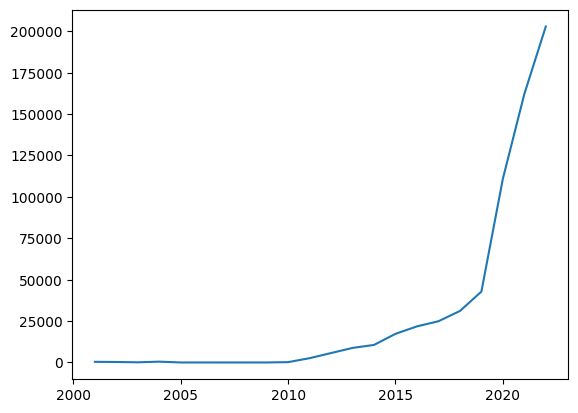

In [3]:
plt.plot(df_france['Year'],df_france['Nb_VE'])

In [4]:
df_comm = pd.read_csv('./data/ve_par_commune.csv')
df_comm.libgeo=df_comm.libgeo.str.lower()
df_comm.head()

,libgeo,date_arrete,nb_vp_rechargeables_el
0,aast,2014-03-31,0.12
1,aast,2014-06-30,0.10
2,aast,2014-09-30,0.09
3,aast,2014-12-31,0.08
4,aast,2015-03-31,0.21


In [5]:
df_cluster=pd.read_csv('./Cluster/data_commune_cluster.csv')
df_cluster=df_cluster[['LIBGEO','cluster']]
df_cluster.LIBGEO=df_cluster.LIBGEO.str.lower()
# df_cluster.drop(['Unnamed: 0','Unnamed: 0.1','codgeo','libgeo','Typologie urbain/rural','latitude','longitude'],axis=1,inplace=True)
df_cluster.head()

,LIBGEO,cluster
0,l'abergement-clémenciat,3
1,l'abergement-de-varey,6
2,ambérieu-en-bugey,35
3,ambérieux-en-dombes,3
4,ambléon,3


In [6]:
big = df_cluster.cluster.unique()

In [7]:
data=df_cluster.merge(df_comm,how='left',right_on='libgeo',left_on='LIBGEO')
data.head()

,LIBGEO,cluster,libgeo,date_arrete,nb_vp_rechargeables_el
0,l'abergement-clémenciat,3,l'abergement-clémenciat,2014-03-31,0.35
1,l'abergement-clémenciat,3,l'abergement-clémenciat,2014-06-30,0.30
2,l'abergement-clémenciat,3,l'abergement-clémenciat,2014-09-30,0.27
3,l'abergement-clémenciat,3,l'abergement-clémenciat,2014-12-31,0.31
4,l'abergement-clémenciat,3,l'abergement-clémenciat,2015-03-31,0.62


In [8]:
# drop nan values
data.dropna(inplace=True)

In [9]:
data.isnull().sum()

LIBGEO                    0
cluster                   0
libgeo                    0
date_arrete               0
nb_vp_rechargeables_el    0
dtype: int64

In [10]:
data.drop(['libgeo'],axis=1,inplace=True)

In [11]:
data.date_arrete=pd.to_datetime(data.date_arrete)

In [12]:
data['year']=data.date_arrete.dt.year

## Nombre de bornes par commune 

In [13]:
df_bornes = pd.read_csv("./data/bornes_par_communes_.csv")
df_bornes.month=df_bornes.month.fillna(1)
df_bornes

,year,month,commune,cumsum
0,2015,1.00,Bagneaux-sur-Loing,2
1,2015,1.00,Beaumont-du-Gâtinais,2
2,2015,1.00,Coulommiers,4
3,2015,1.00,Crécy-la-Chapelle,2
4,2015,1.00,Fontaine-le-Comte,4
...,...,...,...,...
7301,2023,1.00,Vigny,8
7302,2023,1.00,wittes,16
7303,2023,1.00,Cintray,3
7304,2023,1.00,Lesparre-Médoc,6


## Emissions du CO2 en france
http://www.globalcarbonatlas.org/fr/CO2-emissions

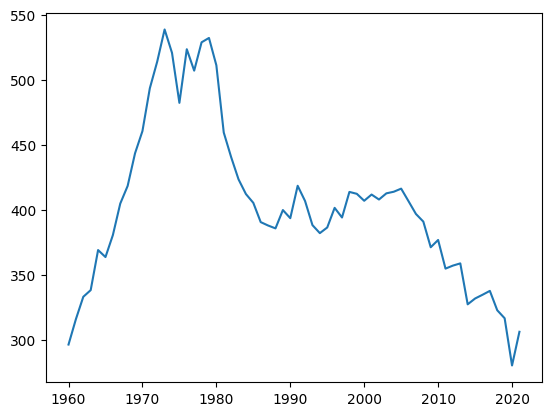

In [14]:
# Émission en MtCO2 en france
df_co2 = pd.read_csv('./data/Emmision_1960-2021.csv',sep=';')
plt.plot(df_co2['année'],df_co2['emissions'])

In [15]:
df_co2.head()

,année,emissions
0,1960,296.14
1,1961,315.71
2,1962,332.91
3,1963,338.04
4,1964,368.88


In [16]:
# add a line to the dataframe
df_co2.loc[len(df_co2)] = [2022,df_co2['emissions'].iloc[-1]]

In [17]:
data=data.merge(df_co2,how='left',left_on='year',right_on='année')
data.drop(['année'],axis=1,inplace=True)
data.head()

,LIBGEO,cluster,date_arrete,nb_vp_rechargeables_el,year,emissions
0,l'abergement-clémenciat,3,2014-03-31,0.35,2014,327.11
1,l'abergement-clémenciat,3,2014-06-30,0.30,2014,327.11
2,l'abergement-clémenciat,3,2014-09-30,0.27,2014,327.11
3,l'abergement-clémenciat,3,2014-12-31,0.31,2014,327.11
4,l'abergement-clémenciat,3,2015-03-31,0.62,2015,331.58


## Trafic routier journalier annuel 
https://www.data.gouv.fr/en/datasets/trafic-moyen-journalier-annuel-sur-le-reseau-routier-national/

In [18]:
def merge_data():
    paths = ['./data/TMJA/TMJA_'+str(i)+'.csv' for i in range(2007,2017)]+['./data/TMJA/tmja-2017.csv','./data/TMJA/tmja2018.csv','./data/TMJA/tmja-2019.csv']
    df = pd.concat([pd.read_csv(path,sep='\t') for path in paths]+[pd.read_csv('./data/TMJA/tmja-2017.csv',sep='\t'),pd.read_csv('./data/TMJA/tmja2018.csv',sep='\t'),pd.read_csv('./data/TMJA/tmja-2019.csv',sep=';')], ignore_index=True)
    # convert date to year
    df['dateReferentiel'] =  pd.to_datetime(df['dateReferentiel']).dt.year
    # goupe by year and department over routes
    df = df.groupby(['dateReferentiel','depPrD']).mean()
    # remove useless columns
    df.drop(['prD','zD','prF','zF','depPrF','anneeMesureTrafic'],axis=1,inplace=True)
    df.to_csv('./data/TMJA_2007-2019.csv')
    df.reset_index(inplace=True)
    # fill nan values with mean
    df.TMJA.fillna(df.TMJA.mean(),inplace=True)
    # add a 96 row to the dataframe 
    for year in [2020,2021,2022]:
        for dep in df.depPrD.unique():
            df.loc[len(df)] = [year,dep,df[df['depPrD'] == dep]['TMJA'].mean()]
    #  use this dataset to get the commune from department codes
    commune_depart=pd.read_csv('./data/communes-departement-region.csv')
    commune_depart=commune_depart[['nom_commune_complet','code_departement']]
    commune_depart.nom_commune_complet=commune_depart.nom_commune_complet.str.lower()
    # merge the two datasets
    df.depPrD=df.depPrD.astype(int).astype(str)
    df=df.merge(commune_depart,how='left',left_on='depPrD',right_on='code_departement')
    # remove useless columns
    df=df[['dateReferentiel','nom_commune_complet','TMJA']]
    return df
df_tmja = merge_data()
df_tmja.tail(2)

,dateReferentiel,nom_commune_complet,TMJA
612910,2022.00,villiers-le-sec,82589.46
612911,2022.00,wy-dit-joli-village,82589.46


In [19]:
# manque cluster 4 et 12
data = data.merge(df_tmja,how='left',left_on=['LIBGEO','year'],right_on=['nom_commune_complet','dateReferentiel'])
data.head()

,LIBGEO,cluster,date_arrete,nb_vp_rechargeables_el,year,emissions,dateReferentiel,nom_commune_complet,TMJA
0,l'abergement-clémenciat,3,2014-03-31,0.35,2014,327.11,2014.00,l'abergement-clémenciat,28156.13
1,l'abergement-clémenciat,3,2014-06-30,0.30,2014,327.11,2014.00,l'abergement-clémenciat,28156.13
2,l'abergement-clémenciat,3,2014-09-30,0.27,2014,327.11,2014.00,l'abergement-clémenciat,28156.13
3,l'abergement-clémenciat,3,2014-12-31,0.31,2014,327.11,2014.00,l'abergement-clémenciat,28156.13
4,l'abergement-clémenciat,3,2015-03-31,0.62,2015,331.58,2015.00,l'abergement-clémenciat,29473.83


In [20]:
data.drop(['LIBGEO','year','dateReferentiel','nom_commune_complet'],axis=1,inplace=True)
data.head()

,cluster,date_arrete,nb_vp_rechargeables_el,emissions,TMJA
0,3,2014-03-31,0.35,327.11,28156.13
1,3,2014-06-30,0.30,327.11,28156.13
2,3,2014-09-30,0.27,327.11,28156.13
3,3,2014-12-31,0.31,327.11,28156.13
4,3,2015-03-31,0.62,331.58,29473.83


## Jointure des données

In [21]:
# aggréger par cluster
df_cluster_ve = data.groupby(['cluster','date_arrete']).mean()
df_cluster_ve = df_cluster_ve.reset_index()

In [22]:
df_cluster_ve['annee'] = df_cluster_ve.date_arrete.dt.year
df_cluster_ve['mois'] = df_cluster_ve.date_arrete.dt.month
df_cluster_ve.drop(['date_arrete'],axis=1,inplace=True)

In [23]:
df_cluster_ve['nb_vp_rechargeables_el'] = df_cluster_ve['nb_vp_rechargeables_el'].astype(int)
df_cluster_ve.head()

,cluster,nb_vp_rechargeables_el,emissions,TMJA,annee,mois
0,0,0,327.11,19921.84,2014,3
1,0,0,327.11,19921.84,2014,6
2,0,0,327.11,19921.84,2014,9
3,0,0,327.11,19921.84,2014,12
4,0,1,331.58,22018.90,2015,3


# Prediction du nombre des véhicules

In [24]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from IPython.display import display, clear_output

In [27]:
train, test = train_test_split(df_cluster_ve, test_size=0.2, random_state=42)

In [28]:
X = train.drop(['nb_vp_rechargeables_el'],axis=1)
y_train = train['nb_vp_rechargeables_el']
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X)
X_test= scaler.transform(test.drop(['nb_vp_rechargeables_el'],axis=1))
y_test = test['nb_vp_rechargeables_el']

In [29]:

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

 17%|█▋        | 7/42 [00:00<00:00, 55.96it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


100%|██████████| 42/42 [00:36<00:00,  1.15it/s]


In [30]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,1.00,1.00,3.50,0.01
XGBRegressor,1.00,1.00,4.44,1.59
ExtraTreeRegressor,1.00,1.00,6.68,0.01
ExtraTreesRegressor,1.00,1.00,21.29,0.18
GradientBoostingRegressor,0.98,0.98,56.55,0.08
RandomForestRegressor,0.84,0.85,145.16,0.25
HistGradientBoostingRegressor,0.81,0.81,160.57,0.36
AdaBoostRegressor,0.79,0.79,167.65,0.02
LGBMRegressor,0.78,0.78,171.76,0.06


In [31]:
# create a Decition Tree model on the training data
# Fit regression model
regr_1 = DecisionTreeRegressor()
regr_1.fit(X_train, y_train)


# Predict
y_1 = regr_1.predict(X_test)



In [32]:
rmse = np.sqrt(mean_squared_error(y_test, y_1))
rmse

3.5437824651894116

In [33]:

def grid_search(name, model, params, verbose=False, cv=5):
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error', verbose=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    clear_output()
    display()
    print(f'[{name}]')
    print(f'best RMSE: {-grid_search.best_score_:.2f}')
    print(f'best hyperparams: {grid_search.best_params_}')
    return grid_search
grid_search_random_forest = grid_search('DecisionTreeRegressor', DecisionTreeRegressor(), params={
    'max_depth': [1,3,5,7,9,11,12],
    'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]})

[DecisionTreeRegressor]
best RMSE: 137.44
best hyperparams: {'max_depth': 9, 'min_samples_leaf': 1}


In [34]:
grid_search_random_forest = grid_search('RandomForestRegressor', RandomForestRegressor(), params={
      'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2', 1.0],
    'min_samples_split': [2, 5]})

[RandomForestRegressor]
best RMSE: 117.53
best hyperparams: {'max_depth': 20, 'max_features': 1.0, 'min_samples_split': 2, 'n_estimators': 100}


In [35]:
# import GradientBoostingRegressor
grid_search_gradient_boosting = grid_search('GradientBoostingRegressor', GradientBoostingRegressor(), params={
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.2, 0.1, 0.05],
    'max_depth': [2, 3, 5],
})

[GradientBoostingRegressor]
best RMSE: 75.99
best hyperparams: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [36]:


# initialize and fit the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

X_test_scaled = scaler.transform(test.drop(['nb_vp_rechargeables_el'],axis=1))
y_test = test['nb_vp_rechargeables_el']
# make predictions
predictions = model.predict(X_test_scaled)
# compute the rmse
rmse = np.sqrt(mean_squared_error(y_test, predictions))
rmse

101.9186641503399

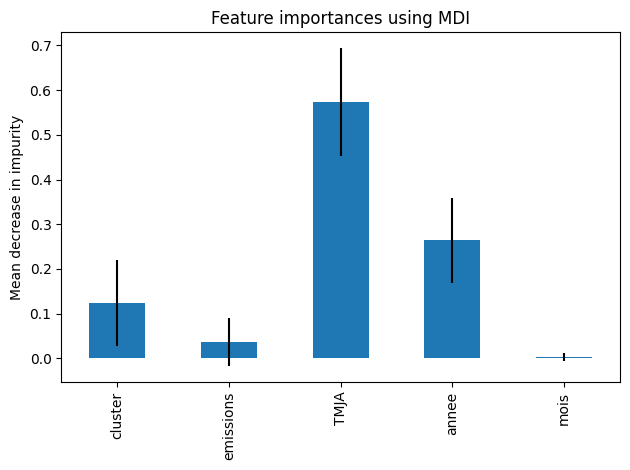

In [37]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

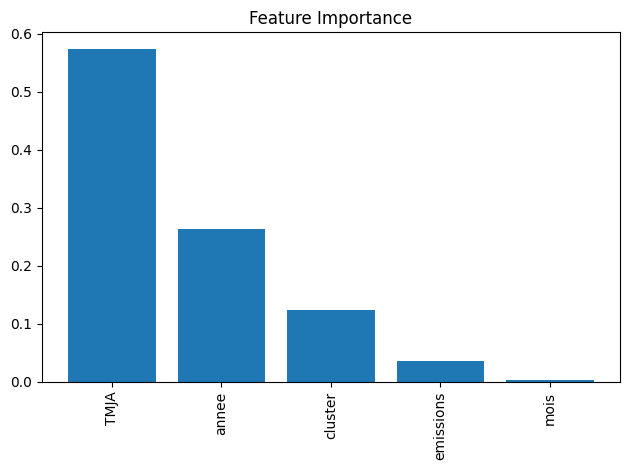

In [38]:

# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [39]:
X = df_cluster_ve.drop(['nb_vp_rechargeables_el'],axis=1)
y = df_cluster_ve['nb_vp_rechargeables_el']
# create an xgboost regression model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 5.712 (3.098)
